In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'assignment2'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/assignment2/cs231n/datasets
/content/drive/My Drive/assignment2


批量标准化

使深度网络更容易训练的一种方法是使用更复杂的优化程序，例如 SGD+momentum、RMSProp 或 Adam。另一种策略是改变网络的架构，使其更容易训练。沿着这些思路的一个想法是批量归一化，由 [1] 在 2015 年提出。

要理解批量归一化的目标，首先要认识到机器学习方法往往在输入数据由具有零均值和单位方差的不相关特征组成的情况下表现更好。在训练神经网络时，我们可以在将数据馈送到网络之前对数据进行预处理，以明确地去相关其特征。这将确保网络的第一层看到遵循良好分布的数据。然而，即使我们对输入数据进行预处理，网络更深层的激活也可能不再去相关并且不再具有零均值或单位方差，因为它们是从网络中较早的层输出的。更糟糕的是，在训练过程中，网络每一层的特征分布会随着每一层权重的更新而变化。

[1] 的作者假设深度神经网络内部特征的变化分布可能会使训练深度网络更加困难。为了克服这个问题，他们建议插入标准化批次的网络层。在训练时，这样的层使用小批量数据来估计每个特征的均值和标准差。然后使用这些估计的均值和标准差来对小批量的特征进行中心化和归一化。在训练期间保留这些均值和标准差的运行平均值，并在测试时使用这些运行平均值对特征进行中心化和归一化。

这种归一化策略可能会降低网络的表示能力，因为对于某些层而言，具有非零均值或单位方差的特征有时可能是最佳的。为此，批量归一化层包括每个特征维度的可学习移位和尺度参数。

[1] [Sergey Ioffe 和 Christian Szegedy，“批量标准化：通过减少
内部协变量移位”，ICML 2015。](https:/v.org/abs/1502.03167)

In [28]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print(f"  means: {x.mean(axis=axis)}")
    print(f"  stds:  {x.std(axis=axis)}\n")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


# Batch Normalization: Forward Pass
In the file `cs231n/layers.py`, implement the batch normalization forward pass in the function `batchnorm_forward`. Once you have done so, run the following to test your implementation.

Referencing the paper linked to above in [1] may be helpful!

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network.
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))

# Means should be close to zero and stds close to one.
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])

# Now means should be close to beta and stds close to gamma.
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means: [ -2.3814598  -13.18038246   1.91780462]
  stds:  [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means: [ 1.55431223e-17  6.21724894e-17 -1.49880108e-17]
  stds:  [0.99999963 0.99999971 0.99999973]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means: [11. 12. 13.]
  stds:  [0.99999963 1.99999942 2.9999992 ]



In [ ]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means: [-0.03927353 -0.04349151 -0.10452686]
  stds:  [1.01531399 1.01238345 0.97819961]



# Batch Normalization: Backward Pass
Now implement the backward pass for batch normalization in the function `batchnorm_backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass.

Once you have finished, run the following to numerically check your backward pass.

In [ ]:
# Gradient check batchnorm backward pass.
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)

# You should expect to see relative errors between 1e-13 and 1e-8.
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.563272893228722e-05
dgamma error:  2.191189131143854e-12
dbeta error:  4.177860269197891e-12


# Batch Normalization: Alternative Backward Pass
在课堂上，我们讨论了 sigmoid 反向传播的两种不同实现。一种策略是通过所有中间值写出由简单操作和反向传播组成的计算图。另一种策略是在纸上计算导数。例如，您可以通过简化纸上的梯度来推导出一个非常简单的 sigmoid 函数的反向传递公式。

令人惊讶的是，事实证明您也可以对批量归一化反向传递进行类似的简化！

在前向传递中，给定一组输入 $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$，

我们首先计算均值 $\mu$ 和方差 $v$。
计算出$\mu$和$v$，我们可以计算出标准差$\sigma$和归一化数据$Y$。
下面的方程和图形说明了计算（$y_i$ 是向量 $Y$ 的第 i 个元素）。

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k & v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon} & y_i=\frac{x_i-\mu}{\sigma}
\end{align}

<img src="https://raw.githubusercontent.com/cs231n/cs231n.github.io/master/assets/a2/batchnorm_graph.png">

我们在反向传播过程中问题的核心是计算 $\frac{\partial L}{\partial X}$，给定我们收到的上游梯度，$\frac{\partial L}{\partial Y}.$ 来做这个，回想一下微积分中的链式法则给我们 $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \frac{\partial Y}{\partial X}$ .

未知/困难的部分是 $\frac{\partial Y}{\partial X}$。我们可以通过首先逐步推导我们的局部梯度来找到这一点
$\frac{\partial v}{\partial X}$, $\frac{\partial \mu}{\partial X}$,
$\frac{\partial \sigma}{\partial v}$,
$\frac{\partial Y}{\partial \sigma}$, 和 $\frac{\partial Y}{\partial \mu}$,
然后使用链式法则适当地组合这些梯度（以向量的形式出现！）来计算 $\frac{\partial Y}{\partial X}$。

如果直接推理需要矩阵乘法的 $X$ 和 $Y$ 上的梯度具有挑战性，请先尝试根据单个元素 $x_i$ 和 $y_i$ 来推理梯度：在这种情况下，您将需要来对 $\frac{\partial L}{\partial x_i}$ 的推导，依靠链式法则首先计算中间 $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ 然后将这些部分组合起来计算 $\frac{\partial y_i}{\partial x_i}$。

您应该确保每个中间梯度推导都尽可能简化，以便于实现。

执行此操作后，在函数“batchnorm_backward_alt”中实现简化的批量归一化向后传递，并通过运行以下命令来比较两个实现。您的两个实现应该计算出几乎相同的结果，但替代实现应该更快一点。

In [ ]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  9.686946159618997e-13
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.36x


# Fully Connected Networks with Batch Normalization
Now that you have a working implementation for batch normalization, go back to your `FullyConnectedNet` in the file `cs231n/classifiers/fc_net.py`. Modify your implementation to add batch normalization.

Concretely, when the `normalization` flag is set to `"batchnorm"` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

**Hint:** You might find it useful to define an additional helper layer similar to those in the file `cs231n/layer_utils.py`.

In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.1631431253070756
W1 relative error: 1.00e+00
W2 relative error: 9.82e-01
W3 relative error: 3.54e-10
b1 relative error: 2.78e-09
b2 relative error: 2.22e-08
b3 relative error: 1.61e-10
beta1 relative error: 1.00e+00
beta2 relative error: 1.74e-09
gamma1 relative error: 1.00e+00
gamma2 relative error: 1.99e-09

Running check with reg =  3.14
Initial loss:  6.992501965152032
W1 relative error: 1.00e+00
W2 relative error: 1.00e+00
W3 relative error: 1.32e-08
b1 relative error: 2.78e-09
b2 relative error: 2.22e-08
b3 relative error: 4.39e-10
beta1 relative error: 9.92e-01
beta2 relative error: 5.72e-09
gamma1 relative error: 9.92e-01
gamma2 relative error: 4.08e-09


# Batch Normalization for Deep Networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [ ]:
np.random.seed(231)

# Try training a very deep net with batchnorm.
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

Solver with batch norm:
(Iteration 1 / 200) loss: 2.340994
(Epoch 0 / 10) train acc: 0.106000; val_acc: 0.116000
(Epoch 1 / 10) train acc: 0.327000; val_acc: 0.272000
(Iteration 21 / 200) loss: 2.007395
(Epoch 2 / 10) train acc: 0.397000; val_acc: 0.286000
(Iteration 41 / 200) loss: 1.974840
(Epoch 3 / 10) train acc: 0.476000; val_acc: 0.303000
(Iteration 61 / 200) loss: 1.715227
(Epoch 4 / 10) train acc: 0.526000; val_acc: 0.309000
(Iteration 81 / 200) loss: 1.245094
(Epoch 5 / 10) train acc: 0.588000; val_acc: 0.323000
(Iteration 101 / 200) loss: 1.219022
(Epoch 6 / 10) train acc: 0.648000; val_acc: 0.336000
(Iteration 121 / 200) loss: 1.119575
(Epoch 7 / 10) train acc: 0.660000; val_acc: 0.315000
(Iteration 141 / 200) loss: 1.161829
(Epoch 8 / 10) train acc: 0.729000; val_acc: 0.333000
(Iteration 161 / 200) loss: 0.744414
(Epoch 9 / 10) train acc: 0.795000; val_acc: 0.332000
(Iteration 181 / 200) loss: 0.878760
(Epoch 10 / 10) train acc: 0.791000; val_acc: 0.328000

Solver without b

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

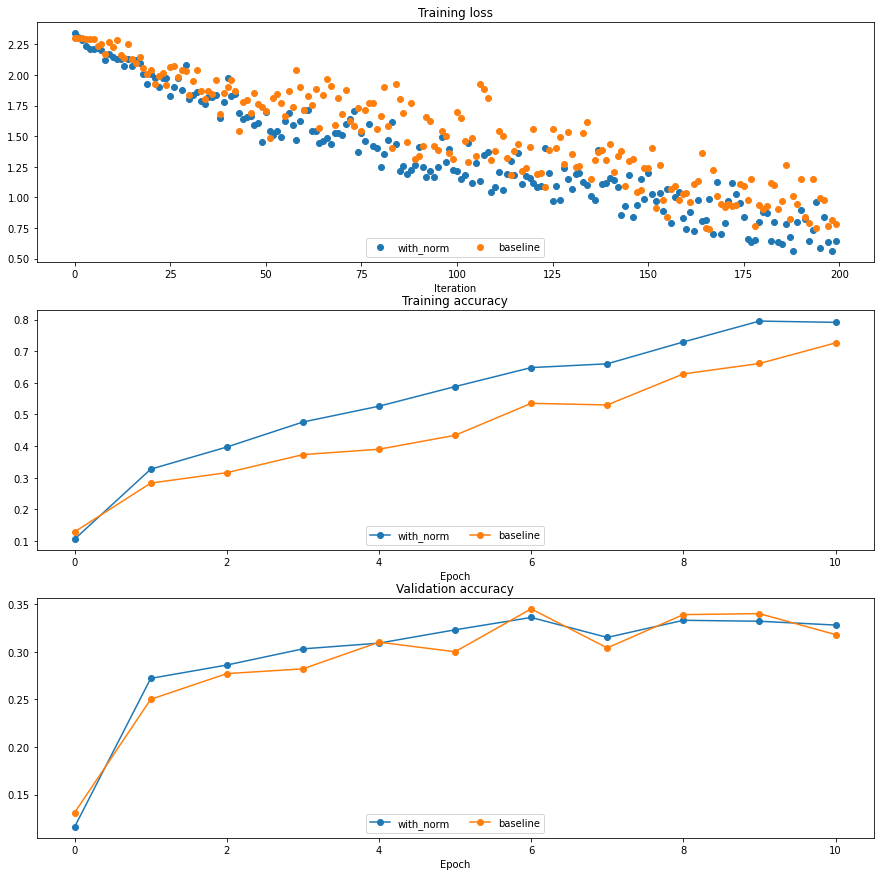

In [ ]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch Normalization and Initialization
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train eight-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [ ]:
np.random.seed(231)

# Try training a very deep net with batchnorm.
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers_ws = {}
solvers_ws = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

    bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers_ws[weight_scale] = bn_solver

    solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    solver.train()
    solvers_ws[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


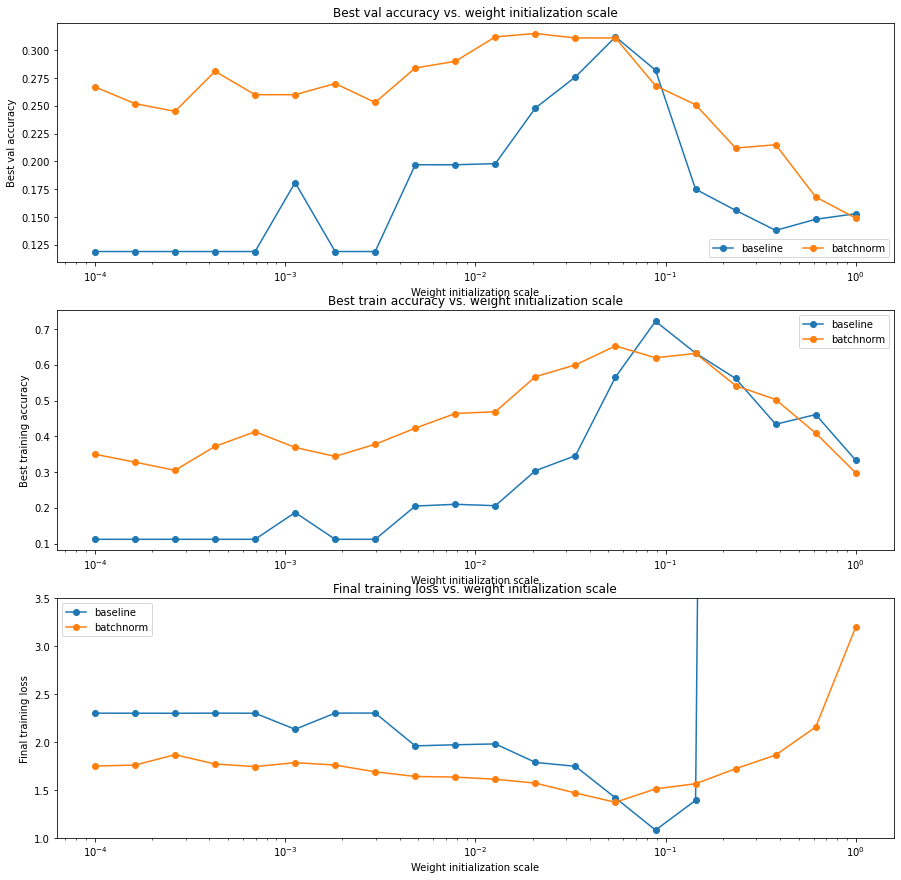

In [ ]:
# Plot results of weight scale experiment.
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers_ws[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers_ws[ws].train_acc_history))
  
  best_val_accs.append(max(solvers_ws[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers_ws[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers_ws[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers_ws[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 1:
Describe the results of this experiment. How does the weight initialization scale affect models with/without batch normalization differently, and why?

## Answer:
[由上图可以得到，BN层使得网络的训练对网络参数初始化变得不那么敏感。不
带BN层，若权重初始化过小，则参数分布逐渐集中在0附近，导致回传的梯度乘以参数之后变得非常小,导致梯度消失。若权重初始化过大，则参数分布逐渐两极化，会出现梯度爆炸现象]


# Batch Normalization and Batch Size
We will now run a small experiment to study the interaction of batch normalization and batch size.

The first cell will train 6-layer networks both with and without batch normalization using different batch sizes. The second layer will plot training accuracy and validation set accuracy over time.

In [20]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    
    # Try training a very deep net with batchnorm.
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


In [21]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

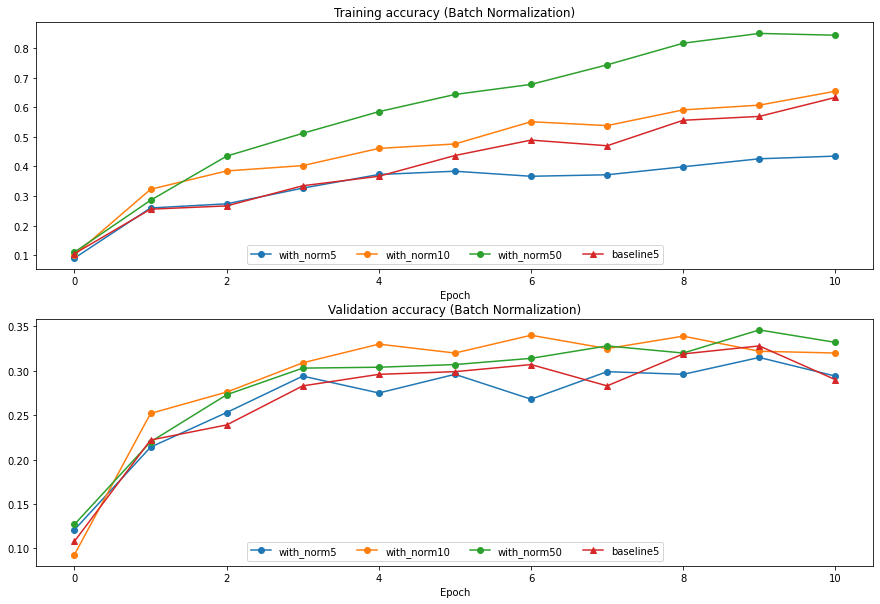

In [8]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 2:
Describe the results of this experiment. What does this imply about the relationship between batch normalization and batch size? Why is this relationship observed?

## Answer:
[在训练模型时，随着批量大小的增加，模型收敛的更快，说明BN层适合大的批量，因为均值和方差估计在大的批量上更准确；在测试的时候，使用的是训练集的滑动平均值，批量大小的影响不是很大，]


# Layer Normalization
事实证明，批量归一化在使网络更容易训练方面是有效的，但对批量大小的依赖使得它在由于硬件限制而对输入批量大小有上限的复杂网络中不太有用。

已经提出了几种批量标准化的替代方案来缓解这个问题； 其中一种技术是层归一化 [2]。 我们不是对批次进行标准化，而是对特征进行标准化。 换句话说，当使用层归一化时，对应于单个数据点的每个特征向量都根据该特征向量中所有项的总和进行归一化。

[2] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)

## Inline Question 3:
Which of these data preprocessing steps is analogous to batch normalization, and which is analogous to layer normalization?

1. Scaling each image in the dataset, so that the RGB channels for each row of pixels within an image sums up to 1.
2. Scaling each image in the dataset, so that the RGB channels for all pixels within an image sums up to 1.  
3. Subtracting the mean image of the dataset from each image in the dataset.
4. Setting all RGB values to either 0 or 1 depending on a given threshold.

## Answer:
[1， 2类似于层归一化， 3类似于批量归一化]


# Layer Normalization: Implementation

Now you'll implement layer normalization. This step should be relatively straightforward, as conceptually the implementation is almost identical to that of batch normalization. One significant difference though is that for layer normalization, we do not keep track of the moving moments, and the testing phase is identical to the training phase, where the mean and variance are directly calculated per datapoint.

Here's what you need to do:

* In `cs231n/layers.py`, implement the forward pass for layer normalization in the function `layernorm_forward`. 

Run the cell below to check your results.
* In `cs231n/layers.py`, implement the backward pass for layer normalization in the function `layernorm_backward`. 

Run the second cell below to check your results.
* Modify `cs231n/classifiers/fc_net.py` to add layer normalization to the `FullyConnectedNet`. When the `normalization` flag is set to `"layernorm"` in the constructor, you should insert a layer normalization layer before each ReLU nonlinearity. 

Run the third cell below to run the batch size experiment on layer normalization.

In [9]:
# Check the training-time forward pass by checking means and variances
# of features both before and after layer normalization.

# Simulate the forward pass for a two-layer network.
np.random.seed(231)
N, D1, D2, D3 =4, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before layer normalization:')
print_mean_std(a,axis=1)

gamma = np.ones(D3)
beta = np.zeros(D3)

# Means should be close to zero and stds close to one.
print('After layer normalization (gamma=1, beta=0)')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

gamma = np.asarray([3.0,3.0,3.0])
beta = np.asarray([5.0,5.0,5.0])

# Now means should be close to beta and stds close to gamma.
print('After layer normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

Before layer normalization:
  means: [-59.06673243 -47.60782686 -43.31137368 -26.40991744]
  stds:  [10.07429373 28.39478981 35.28360729  4.01831507]

After layer normalization (gamma=1, beta=0)
  means: [ 4.81096644e-16 -7.40148683e-17  2.22044605e-16 -5.92118946e-16]
  stds:  [0.99999995 0.99999999 1.         0.99999969]

After layer normalization (gamma= [3. 3. 3.] , beta= [5. 5. 5.] )
  means: [5. 5. 5. 5.]
  stds:  [2.99999985 2.99999998 2.99999999 2.99999907]



In [10]:
# Gradient check batchnorm backward pass.
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

ln_param = {}
fx = lambda x: layernorm_forward(x, gamma, beta, ln_param)[0]
fg = lambda a: layernorm_forward(x, a, beta, ln_param)[0]
fb = lambda b: layernorm_forward(x, gamma, b, ln_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = layernorm_forward(x, gamma, beta, ln_param)
dx, dgamma, dbeta = layernorm_backward(dout, cache)

# You should expect to see relative errors between 1e-12 and 1e-8.
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.4336155301072336e-09
dgamma error:  4.519489546032799e-12
dbeta error:  2.276445013433725e-12


# Layer Normalization and Batch Size

We will now run the previous batch size experiment with layer normalization instead of batch normalization. Compared to the previous experiment, you should see a markedly smaller influence of batch size on the training history!

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


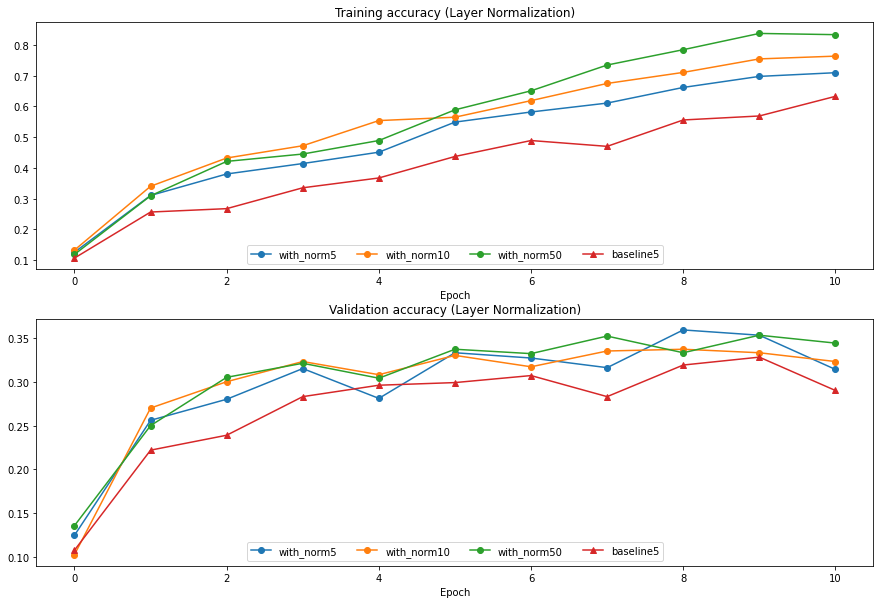

In [30]:
ln_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('layernorm')

plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 4:
When is layer normalization likely to not work well, and why?

1. Using it in a very deep network
2. Having a very small dimension of features
3. Having a high regularization term


## Answer:
[2.特征维度较小时，层归一化容易受到噪声项的影响，效果较差

3.有较大的正则化系数时，模型容易欠拟合，层归一化效果较差。]
